ASTRONOMICAL IMAGE PREPROCESSING FOR EQUIRECTANGULAR PROJECTION
Loading astronomical images...
Panorama shape: (5000, 10000, 3)
Star Template 1 shape: (75, 77, 3)
Star Template 2 shape: (75, 80, 3)

Analyzing original image quality...
Original Panorama:
  Brightness: 28.0 → 28.0
  Contrast: 36.2 → 36.2
  Bright pixels (>200): 238830 → 238830

Starting astronomical image preprocessing...
Removing light pollution gradient...
Applying adaptive denoising...
Enhancing star features...
Applying final contrast enhancement...
Preprocessing star template 1...
Preprocessing star template 2...

Analyzing processed image quality...
Processed Panorama:
  Brightness: 28.0 → 12.1
  Contrast: 36.2 → 28.1
  Bright pixels (>200): 238830 → 419200

Visualizing preprocessing results...


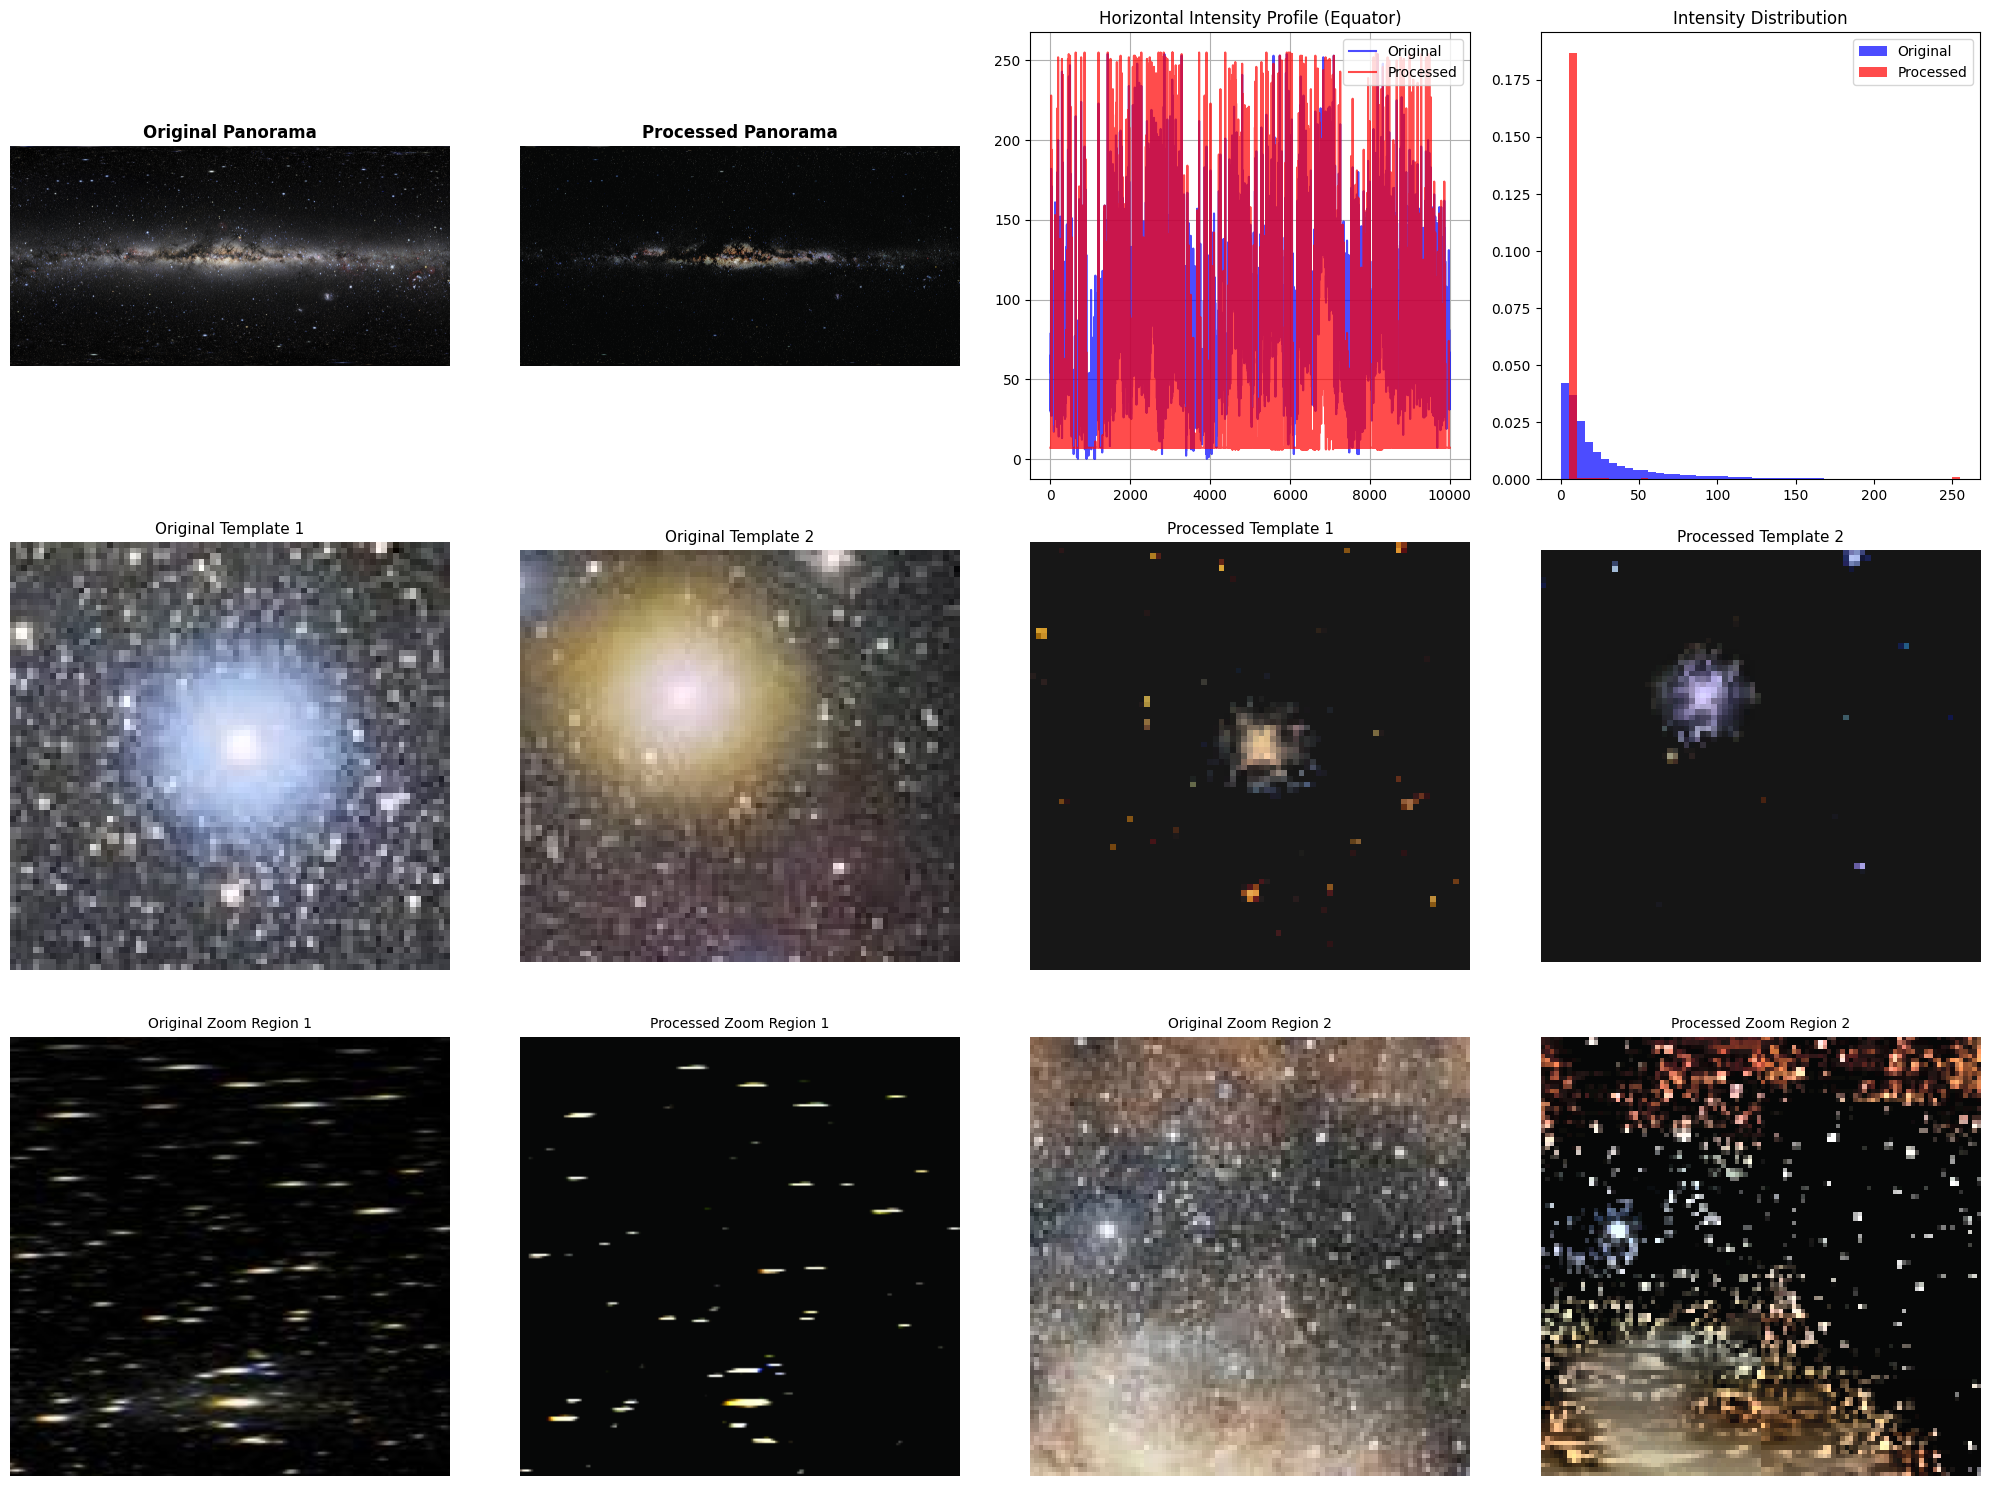


Astronomical preprocessing completed!
Saved files:
- processed_astronomical_panorama.jpg
- processed_star_template_1.jpg
- processed_star_template_2.jpg
- astronomical_preprocessing_results.jpg


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure, filters

def load_astronomical_images():
    """Load the large equirectangular image and star templates"""
    print("Loading astronomical images...")
    
    # Load the large equirectangular panorama
    panorama_path = 'data/output_smart.jpg'
    template_paths = [
        'data/output_smart_crop_001 (1).jpg',
        'data/output_smart_crop_002 (1).jpg'
    ]
    
    panorama = cv2.imread(panorama_path)
    if panorama is None:
        raise FileNotFoundError(f"Panorama image not found at {panorama_path}")
    
    # Load template images
    templates = []
    for i, template_path in enumerate(template_paths):
        template = cv2.imread(template_path)
        if template is None:
            raise FileNotFoundError(f"Template {i+1} not found at {template_path}")
        templates.append(template)
    
    # Convert from BGR to RGB for processing
    panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)
    templates = [cv2.cvtColor(t, cv2.COLOR_BGR2RGB) for t in templates]
    
    print(f"Panorama shape: {panorama.shape}")
    for i, template in enumerate(templates):
        print(f"Star Template {i+1} shape: {template.shape}")
    
    return panorama, templates

def enhance_stars_astronomical(image, clip_limit=3.0, tile_size=32):
    """
    Specialized enhancement for astronomical images to highlight stars
    """
    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l_channel, a, b = cv2.split(lab)
    
    # Apply CLAHE specifically to the lightness channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size, tile_size))
    l_enhanced = clahe.apply(l_channel)
    
    # Merge back and convert to RGB
    lab_enhanced = cv2.merge([l_enhanced, a, b])
    enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2RGB)
    
    return enhanced

def adaptive_denoising_equirectangular(image, strength=10):
    """
    Adaptive denoising that considers equirectangular projection
    More aggressive denoising at poles where distortion is high
    """
    height, width = image.shape[:2]
    denoised = np.zeros_like(image, dtype=np.float32)
    
    # Process image in vertical strips to account for projection distortion
    strip_width = width // 10  # Process in 10 vertical strips
    
    for i in range(0, width, strip_width):
        end_i = min(i + strip_width, width)
        strip = image[:, i:end_i]
        
        # Calculate latitude-based denoising strength
        # More denoising at poles (top and bottom), less at equator
        center_y = height // 2
        for y in range(strip.shape[0]):
            # Latitude factor: 1.0 at poles, 0.5 at equator
            lat_factor = 1.0 - 0.5 * np.cos(2 * np.pi * (y / height))
            strip_strength = strength * lat_factor
            
            # Apply denoising to this row
            denoised_row = cv2.fastNlMeansDenoisingColored(
                strip[y:y+1, :], None, strip_strength, strip_strength*0.8, 7, 21
            )
            denoised[y, i:end_i] = denoised_row[0]
    
    return denoised.astype(np.uint8)

def remove_light_pollution(image, percentile=95):
    """
    Remove light pollution gradient common in astronomical images
    """
    # Estimate background using percentile filtering
    background_estimate = np.percentile(image.astype(np.float32), percentile, axis=(0, 1))
    
    # Subtract background and scale
    corrected = image.astype(np.float32) - background_estimate
    corrected = np.clip(corrected, 0, 255).astype(np.uint8)
    
    return corrected

def enhance_star_features(image):
    """
    Enhance star features using morphological operations and sharpening
    """
    # Convert to grayscale for star enhancement
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Top-hat transform to enhance bright features (stars)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    
    # Add the enhanced stars back to the original image
    enhanced_stars = cv2.addWeighted(gray, 1.0, tophat, 2.0, 0)
    
    # Convert back to color by applying the enhancement to all channels
    enhanced = image.copy().astype(np.float32)
    for channel in range(3):
        enhanced[:, :, channel] = enhanced[:, :, channel] * (enhanced_stars / (gray + 1e-6))
    
    enhanced = np.clip(enhanced, 0, 255).astype(np.uint8)
    
    return enhanced

def preprocess_astronomical_panorama(panorama):
    """
    Complete preprocessing pipeline for astronomical equirectangular image
    """
    print("Starting astronomical image preprocessing...")
    
    # 1. Initial light pollution removal
    print("Removing light pollution gradient...")
    no_light_pollution = remove_light_pollution(panorama)
    
    # 2. Adaptive denoising based on latitude
    print("Applying adaptive denoising...")
    denoised = adaptive_denoising_equirectangular(no_light_pollution)
    
    # 3. Star-specific enhancement
    print("Enhancing star features...")
    star_enhanced = enhance_star_features(denoised)
    
    # 4. Final contrast enhancement
    print("Applying final contrast enhancement...")
    final_enhanced = enhance_stars_astronomical(star_enhanced, clip_limit=4.0, tile_size=64)
    
    return final_enhanced

def preprocess_star_templates(templates):
    """
    Preprocess star templates with same parameters as panorama
    """
    processed_templates = []
    
    for i, template in enumerate(templates):
        print(f"Preprocessing star template {i+1}...")
        
        # Apply similar processing but without adaptive denoising
        no_light_pollution = remove_light_pollution(template)
        star_enhanced = enhance_star_features(no_light_pollution)
        final_enhanced = enhance_stars_astronomical(star_enhanced, clip_limit=4.0, tile_size=16)
        
        processed_templates.append(final_enhanced)
    
    return processed_templates

def visualize_astronomical_preprocessing(original, processed, templates, processed_templates):
    """
    Visualize the preprocessing results for astronomical images
    """
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    # Original panorama
    axes[0, 0].imshow(original)
    axes[0, 0].set_title('Original Panorama', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Processed panorama
    axes[0, 1].imshow(processed)
    axes[0, 1].set_title('Processed Panorama', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    # Intensity profile comparison
    orig_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    proc_gray = cv2.cvtColor(processed, cv2.COLOR_RGB2GRAY)
    
    middle_row = original.shape[0] // 2
    axes[0, 2].plot(orig_gray[middle_row, :], 'b-', label='Original', alpha=0.7)
    axes[0, 2].plot(proc_gray[middle_row, :], 'r-', label='Processed', alpha=0.7)
    axes[0, 2].set_title('Horizontal Intensity Profile (Equator)')
    axes[0, 2].legend()
    axes[0, 2].grid(True)
    
    # Histogram comparison
    axes[0, 3].hist(orig_gray.ravel(), bins=50, alpha=0.7, color='blue', 
                   label='Original', density=True)
    axes[0, 3].hist(proc_gray.ravel(), bins=50, alpha=0.7, color='red', 
                   label='Processed', density=True)
    axes[0, 3].set_title('Intensity Distribution')
    axes[0, 3].legend()
    
    # Show original templates
    for i in range(2):
        axes[1, i].imshow(templates[i])
        axes[1, i].set_title(f'Original Template {i+1}', fontsize=11)
        axes[1, i].axis('off')
    
    # Show processed templates
    for i in range(2):
        axes[1, i+2].imshow(processed_templates[i])
        axes[1, i+2].set_title(f'Processed Template {i+1}', fontsize=11)
        axes[1, i+2].axis('off')
    
    # Zoomed-in regions for detail comparison
    zoom_regions = [
        (100, 100, 200, 200),  # Top-left region (polar)
        (original.shape[0]//2 - 50, original.shape[1]//2 - 50, 100, 100)  # Center (equatorial)
    ]
    
    for i, (y, x, h, w) in enumerate(zoom_regions):
        orig_zoom = original[y:y+h, x:x+w]
        proc_zoom = processed[y:y+h, x:x+w]
        
        axes[2, i*2].imshow(orig_zoom)
        axes[2, i*2].set_title(f'Original Zoom Region {i+1}', fontsize=10)
        axes[2, i*2].axis('off')
        
        axes[2, i*2+1].imshow(proc_zoom)
        axes[2, i*2+1].set_title(f'Processed Zoom Region {i+1}', fontsize=10)
        axes[2, i*2+1].axis('off')
    
    plt.tight_layout()
    plt.savefig('astronomical_preprocessing_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_astronomical_quality(original, processed, name):
    """Analyze quality metrics for astronomical images"""
    orig_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    proc_gray = cv2.cvtColor(processed, cv2.COLOR_RGB2GRAY)
    
    # Calculate metrics
    brightness_orig = np.mean(orig_gray)
    brightness_proc = np.mean(proc_gray)
    contrast_orig = np.std(orig_gray)
    contrast_proc = np.std(proc_gray)
    
    # Star-specific metrics (assuming stars are bright points)
    star_threshold = 200
    stars_orig = np.sum(orig_gray > star_threshold)
    stars_proc = np.sum(proc_gray > star_threshold)
    
    print(f"{name}:")
    print(f"  Brightness: {brightness_orig:.1f} → {brightness_proc:.1f}")
    print(f"  Contrast: {contrast_orig:.1f} → {contrast_proc:.1f}")
    print(f"  Bright pixels (>200): {stars_orig} → {stars_proc}")
    print()

def main_astronomical_preprocessing():
    """Main function for astronomical image preprocessing"""
    print("=" * 70)
    print("ASTRONOMICAL IMAGE PREPROCESSING FOR EQUIRECTANGULAR PROJECTION")
    print("=" * 70)
    
    # Load images
    panorama, templates = load_astronomical_images()
    
    print("\nAnalyzing original image quality...")
    analyze_astronomical_quality(panorama, panorama, "Original Panorama")
    
    # Preprocess panorama
    processed_panorama = preprocess_astronomical_panorama(panorama)
    
    # Preprocess templates
    processed_templates = preprocess_star_templates(templates)
    
    print("\nAnalyzing processed image quality...")
    analyze_astronomical_quality(panorama, processed_panorama, "Processed Panorama")
    
    print("Visualizing preprocessing results...")
    visualize_astronomical_preprocessing(panorama, processed_panorama, templates, processed_templates)
    
    # Save processed images
    cv2.imwrite('output-q4/processed_astronomical_panorama.jpg', cv2.cvtColor(processed_panorama, cv2.COLOR_RGB2BGR))
    for i, template in enumerate(processed_templates):
        cv2.imwrite(f'output-q4/processed_star_template_{i+1}.jpg', cv2.cvtColor(template, cv2.COLOR_RGB2BGR))
    
    print("\nAstronomical preprocessing completed!")
    print("Saved files:")
    print("- processed_astronomical_panorama.jpg")
    print("- processed_star_template_1.jpg")
    print("- processed_star_template_2.jpg")
    print("- astronomical_preprocessing_results.jpg")
    
    return processed_panorama, processed_templates

if __name__ == "__main__":
    processed_panorama, processed_templates = main_astronomical_preprocessing()

/var/folders/3y/x88zbv4n0b18f8cg1qcv1my40000gn/T/ipykernel_32217/2726565357.py:4: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy import ndimage


ASTRONOMICAL TEMPLATE MATCHING
Loaded preprocessed astronomical images successfully!

Performing multi-template matching...
Matching star template 1...
  Threshold 0.5: Found 31 matches
Matching star template 2...
  Threshold 0.5: Found 54 matches

Visualizing matching results...


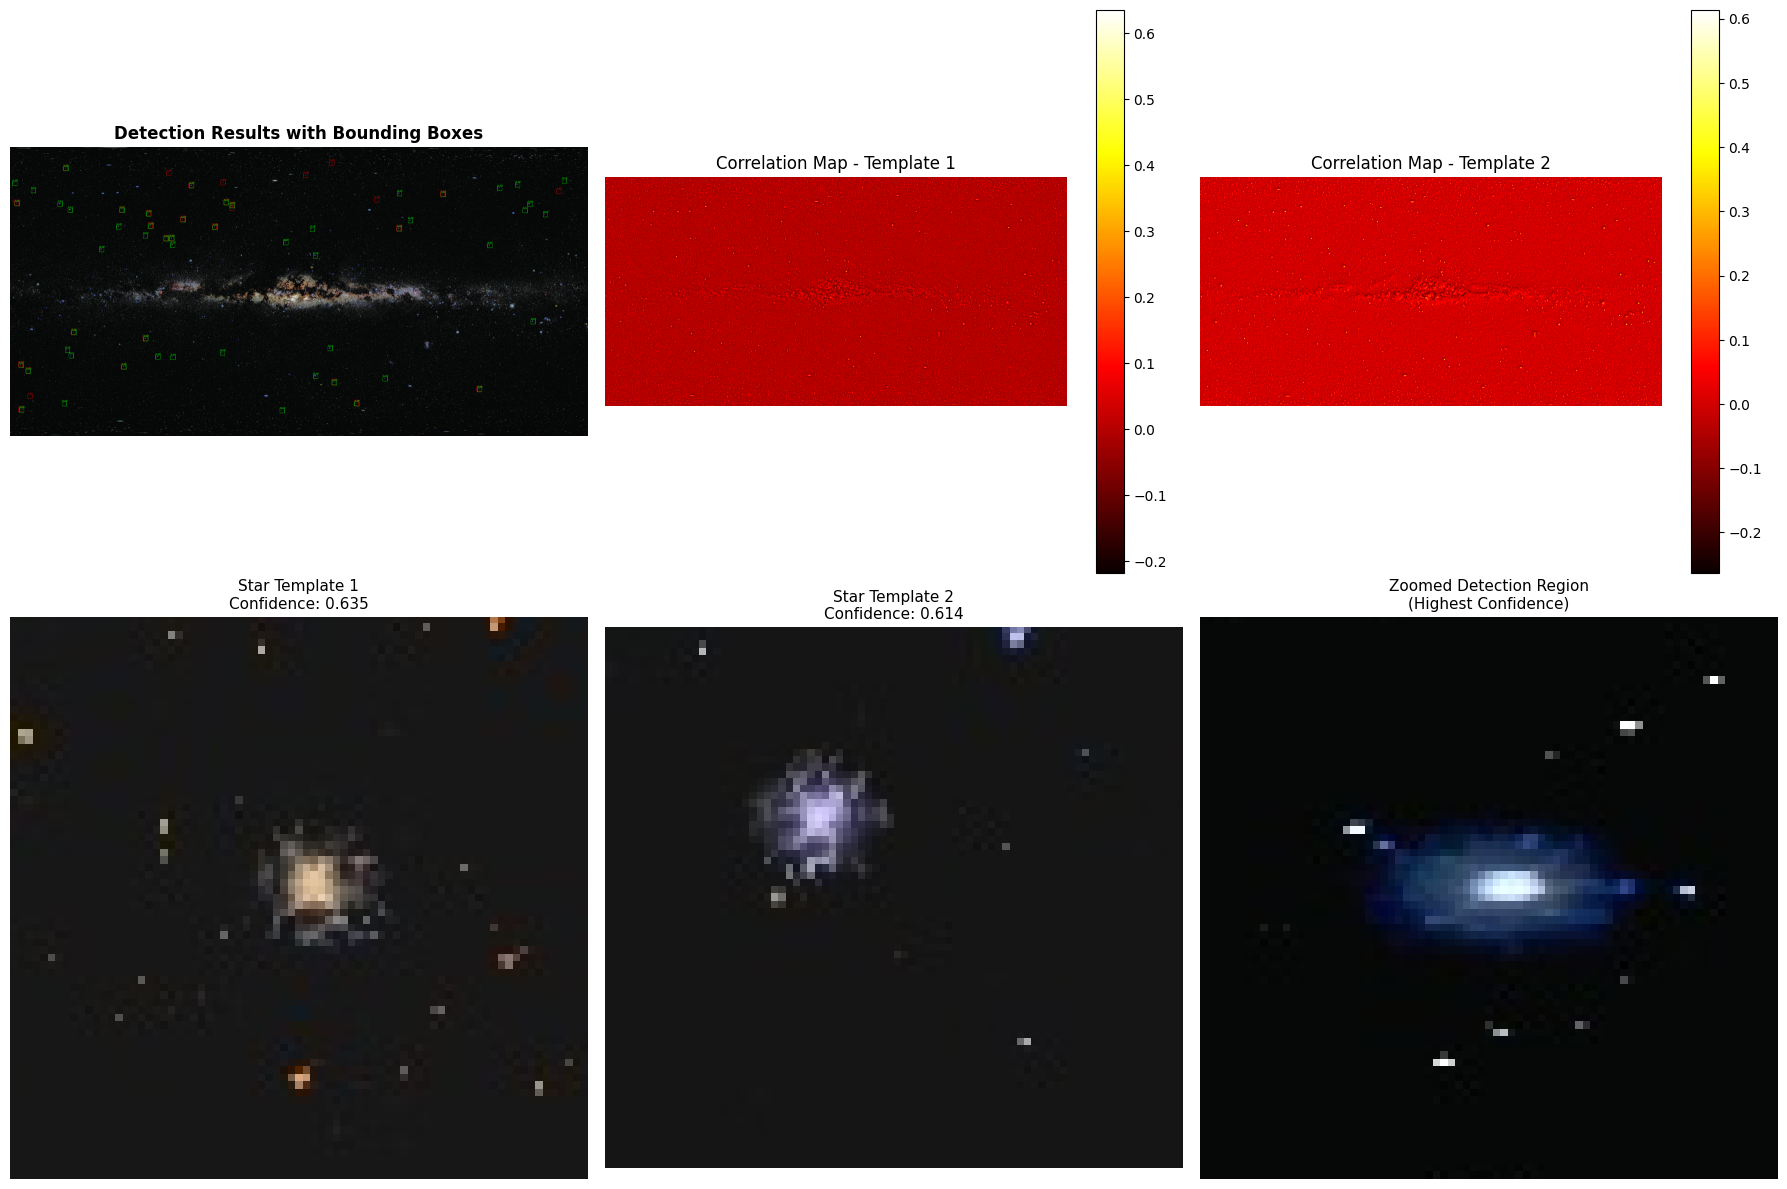

BOUNDING BOX COORDINATES

Star Template 1:
------------------------------
  Match 1:
    Bounding Box: (x=8074, y=4151, width=77, height=75)
    Confidence: 0.635
  Match 2:
    Bounding Box: (x=267, y=3836, width=77, height=75)
    Confidence: 0.608
  Match 3:
    Bounding Box: (x=3693, y=919, width=77, height=75)
    Confidence: 0.587
  Match 4:
    Bounding Box: (x=1920, y=3761, width=77, height=75)
    Confidence: 0.569
  Match 5:
    Bounding Box: (x=7445, y=776, width=77, height=75)
    Confidence: 0.548
  Match 6:
    Bounding Box: (x=5562, y=4034, width=77, height=75)
    Confidence: 0.541
  Match 7:
    Bounding Box: (x=6685, y=1372, width=77, height=75)
    Confidence: 0.540
  Match 8:
    Bounding Box: (x=2749, y=1539, width=77, height=75)
    Confidence: 0.539
  Match 9:
    Bounding Box: (x=1055, y=3164, width=77, height=75)
    Confidence: 0.539
  Match 10:
    Bounding Box: (x=144, y=3729, width=77, height=75)
    Confidence: 0.533
  Match 11:
    Bounding Box: (x=5532, 

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage

def multi_scale_template_matching(scene, template, scale_factors=[0.8, 0.9, 1.0, 1.1, 1.2]):
    """
    Multi-scale template matching to handle size variations in equirectangular projection
    """
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    
    best_confidence = -1
    best_location = None
    best_scale = 1.0
    best_result = None
    
    for scale in scale_factors:
        # Resize template
        new_width = int(template_gray.shape[1] * scale)
        new_height = int(template_gray.shape[0] * scale)
        
        if new_width < 10 or new_height < 10 or new_width > scene_gray.shape[1] or new_height > scene_gray.shape[0]:
            continue
            
        resized_template = cv2.resize(template_gray, (new_width, new_height))
        
        # Perform template matching
        result = cv2.matchTemplate(scene_gray, resized_template, cv2.TM_CCOEFF_NORMED)
        
        # Find best match for this scale
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        
        if max_val > best_confidence:
            best_confidence = max_val
            best_location = max_loc
            best_scale = scale
            best_result = result
    
    if best_confidence > 0:
        # Calculate actual template size at best scale
        actual_width = int(template_gray.shape[1] * best_scale)
        actual_height = int(template_gray.shape[0] * best_scale)
        
        return {
            'top_left': best_location,
            'bottom_right': (best_location[0] + actual_width, best_location[1] + actual_height),
            'confidence': best_confidence,
            'scale': best_scale,
            'result_map': best_result
        }
    else:
        return None

def find_all_matches(scene, template, threshold=0.6):
    """
    Find all matches above threshold with non-maximum suppression
    """
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    
    result = cv2.matchTemplate(scene_gray, template_gray, cv2.TM_CCOEFF_NORMED)
    
    # Find all locations above threshold
    locations = np.where(result >= threshold)
    
    matches = []
    for pt in zip(*locations[::-1]):  # Switch x and y coordinates
        matches.append({
            'top_left': pt,
            'bottom_right': (pt[0] + template_gray.shape[1], pt[1] + template_gray.shape[0]),
            'confidence': result[pt[1], pt[0]]
        })
    
    # Apply non-maximum suppression
    matches = non_max_suppression(matches)
    
    return matches

def non_max_suppression(matches, overlap_threshold=0.3):
    """
    Apply non-maximum suppression to remove overlapping detections
    """
    if len(matches) == 0:
        return []
    
    # Convert to numpy array for easier processing
    boxes = np.array([[
        m['top_left'][0], 
        m['top_left'][1], 
        m['bottom_right'][0] - m['top_left'][0],
        m['bottom_right'][1] - m['top_left'][1],
        m['confidence']
    ] for m in matches])
    
    # Apply NMS
    pick = []
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 0] + boxes[:, 2]
    y2 = boxes[:, 1] + boxes[:, 3]
    scores = boxes[:, 4]
    
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)[::-1]  # Sort in descending order
    
    while len(idxs) > 0:
        i = idxs[0]
        pick.append(i)
        
        if len(idxs) == 1:
            break
            
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        
        overlap = (w * h) / area[idxs[1:]]
        
        idxs = idxs[np.where(overlap <= overlap_threshold)[0] + 1]
    
    return [matches[i] for i in pick]

def astronomical_template_matching(scene, templates, thresholds=[0.5, 0.4, 0.3]):
    """
    Specialized template matching for astronomical images
    """
    all_matches = []
    all_correlation_maps = []
    
    for i, template in enumerate(templates):
        print(f"Matching star template {i+1}...")
        
        best_matches = []
        best_threshold = None
        
        # Try multiple thresholds
        for threshold in thresholds:
            matches = find_all_matches(scene, template, threshold=threshold)
            if matches:
                best_matches = matches
                best_threshold = threshold
                print(f"  Threshold {threshold}: Found {len(matches)} matches")
                break
        
        # If no matches found, try multi-scale approach
        if not best_matches:
            print("  No matches found with standard method, trying multi-scale...")
            multi_scale_result = multi_scale_template_matching(scene, template)
            if multi_scale_result:
                best_matches = [multi_scale_result]
                best_threshold = "multi-scale"
                print(f"  Multi-scale: Found 1 match with confidence {multi_scale_result['confidence']:.3f}")
        
        all_matches.append(best_matches)
        
        # Store correlation map for visualization
        if best_matches:
            result_map, _, _ = template_matching_cross_correlation(scene, template)
            all_correlation_maps.append(result_map)
        else:
            all_correlation_maps.append(None)
    
    return all_matches, all_correlation_maps

def template_matching_cross_correlation(scene, template, method=cv2.TM_CCOEFF_NORMED):
    """
    Basic cross-correlation template matching
    """
    scene_gray = cv2.cvtColor(scene, cv2.COLOR_RGB2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
    
    result = cv2.matchTemplate(scene_gray, template_gray, method)
    
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        confidence = 1 - min_val
        top_left = min_loc
    else:
        confidence = max_val
        top_left = max_loc
    
    return result, top_left, confidence

def visualize_astronomical_matching(original_scene, templates, all_matches, correlation_maps=None):
    """
    Visualize template matching results for astronomical images
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Original scene with bounding boxes
    result_image = original_scene.copy()
    colors = [(255, 0, 0), (0, 255, 0)]  # Red for template 1, Green for template 2
    
    for i, matches in enumerate(all_matches):
        for match in matches:
            cv2.rectangle(result_image, match['top_left'], match['bottom_right'], 
                         colors[i], 3)
            cv2.putText(result_image, f'T{i+1}: {match["confidence"]:.2f}', 
                       (match['top_left'][0], match['top_left'][1]-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)
    
    axes[0, 0].imshow(result_image)
    axes[0, 0].set_title('Detection Results with Bounding Boxes', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Show correlation maps
    if correlation_maps and correlation_maps[0] is not None:
        im = axes[0, 1].imshow(correlation_maps[0], cmap='hot')
        axes[0, 1].set_title('Correlation Map - Template 1', fontsize=12)
        axes[0, 1].axis('off')
        plt.colorbar(im, ax=axes[0, 1])
    
    if correlation_maps and len(correlation_maps) > 1 and correlation_maps[1] is not None:
        im = axes[0, 2].imshow(correlation_maps[1], cmap='hot')
        axes[0, 2].set_title('Correlation Map - Template 2', fontsize=12)
        axes[0, 2].axis('off')
        plt.colorbar(im, ax=axes[0, 2])
    
    # Show templates and zoomed detection regions
    for i, template in enumerate(templates[:2]):
        axes[1, i].imshow(template)
        title = f'Star Template {i+1}'
        if i < len(all_matches) and all_matches[i]:
            best_match = max(all_matches[i], key=lambda x: x['confidence'])
            title += f'\nConfidence: {best_match["confidence"]:.3f}'
        axes[1, i].set_title(title, fontsize=11)
        axes[1, i].axis('off')
    
    # Show zoomed detection region for the best match
    if all_matches and any(all_matches):
        best_overall_match = None
        for matches in all_matches:
            if matches:
                match_candidate = max(matches, key=lambda x: x['confidence'])
                if best_overall_match is None or match_candidate['confidence'] > best_overall_match['confidence']:
                    best_overall_match = match_candidate
        
        if best_overall_match:
            x1, y1 = best_overall_match['top_left']
            x2, y2 = best_overall_match['bottom_right']
            zoom_region = original_scene[y1:y2, x1:x2]
            
            axes[1, 2].imshow(zoom_region)
            axes[1, 2].set_title('Zoomed Detection Region\n(Highest Confidence)', fontsize=11)
            axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('astronomical_matching_results.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    
    return result_image

def output_bounding_box_coordinates(all_matches):
    """
    Output bounding box coordinates in the required format
    """
    print("=" * 70)
    print("BOUNDING BOX COORDINATES")
    print("=" * 70)
    
    for i, matches in enumerate(all_matches):
        print(f"\nStar Template {i+1}:")
        print("-" * 30)
        
        if not matches:
            print("  No matches found")
            continue
            
        for j, match in enumerate(matches):
            x, y = match['top_left']
            width = match['bottom_right'][0] - x
            height = match['bottom_right'][1] - y
            
            print(f"  Match {j+1}:")
            print(f"    Bounding Box: (x={x}, y={y}, width={width}, height={height})")
            print(f"    Confidence: {match['confidence']:.3f}")
            
            if 'scale' in match:
                print(f"    Scale factor: {match['scale']:.2f}")

def analyze_matching_effectiveness(original_scene, templates, all_matches):
    """
    Analyze the effectiveness of the template matching
    """
    print("\n" + "=" * 70)
    print("MATCHING EFFECTIVENESS ANALYSIS")
    print("=" * 70)
    
    scene_gray = cv2.cvtColor(original_scene, cv2.COLOR_RGB2GRAY)
    total_matches = sum(len(matches) for matches in all_matches)
    
    print(f"Total matches found: {total_matches}")
    
    for i, (template, matches) in enumerate(zip(templates, all_matches)):
        template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
        
        print(f"\nTemplate {i+1} Analysis:")
        print(f"  Matches found: {len(matches)}")
        
        if matches:
            best_match = max(matches, key=lambda x: x['confidence'])
            print(f"  Best confidence: {best_match['confidence']:.3f}")
            
            # Calculate additional quality metrics for best match
            x1, y1 = best_match['top_left']
            x2, y2 = best_match['bottom_right']
            roi = scene_gray[y1:y2, x1:x2]
            
            if roi.shape[0] > 0 and roi.shape[1] > 0:
                if roi.shape != template_gray.shape:
                    roi = cv2.resize(roi, (template_gray.shape[1], template_gray.shape[0]))
                
                # Calculate MSE
                mse = np.mean((template_gray.astype(float) - roi.astype(float)) ** 2)
                print(f"  MSE for best match: {mse:.2f}")
                
                # Calculate correlation coefficient
                correlation = np.corrcoef(template_gray.flatten(), roi.flatten())[0, 1]
                print(f"  Correlation coefficient: {correlation:.3f}")

def main_astronomical_matching():
    """Main function for astronomical template matching"""
    print("=" * 70)
    print("ASTRONOMICAL TEMPLATE MATCHING")
    print("=" * 70)
    
    # Load preprocessed images
    try:
        scene = cv2.imread('output-q4/processed_astronomical_panorama.jpg')
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        
        templates = []
        for i in range(1, 3):
            template = cv2.imread(f'output-q4/processed_star_template_{i}.jpg')
            template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
            templates.append(template)
        
        print("Loaded preprocessed astronomical images successfully!")
        
    except Exception as e:
        print(f"Error loading preprocessed images: {e}")
        print("Please run the preprocessing step first.")
        return
    
    # Perform template matching
    print("\nPerforming multi-template matching...")
    all_matches, correlation_maps = astronomical_template_matching(scene, templates)
    
    # Visualize results
    print("\nVisualizing matching results...")
    result_image = visualize_astronomical_matching(scene, templates, all_matches, correlation_maps)
    
    # Output bounding box coordinates
    output_bounding_box_coordinates(all_matches)
    
    # Analyze effectiveness
    analyze_matching_effectiveness(scene, templates, all_matches)
    
    # Save final result
    cv2.imwrite('final_astronomical_detection.jpg', cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
    
    print("\n" + "=" * 70)
    print("PROCESSING COMPLETED")
    print("=" * 70)
    print("Saved files:")
    print("- final_astronomical_detection.jpg")
    print("- astronomical_matching_results.jpg")
    
    return all_matches

if __name__ == "__main__":
    matches = main_astronomical_matching()